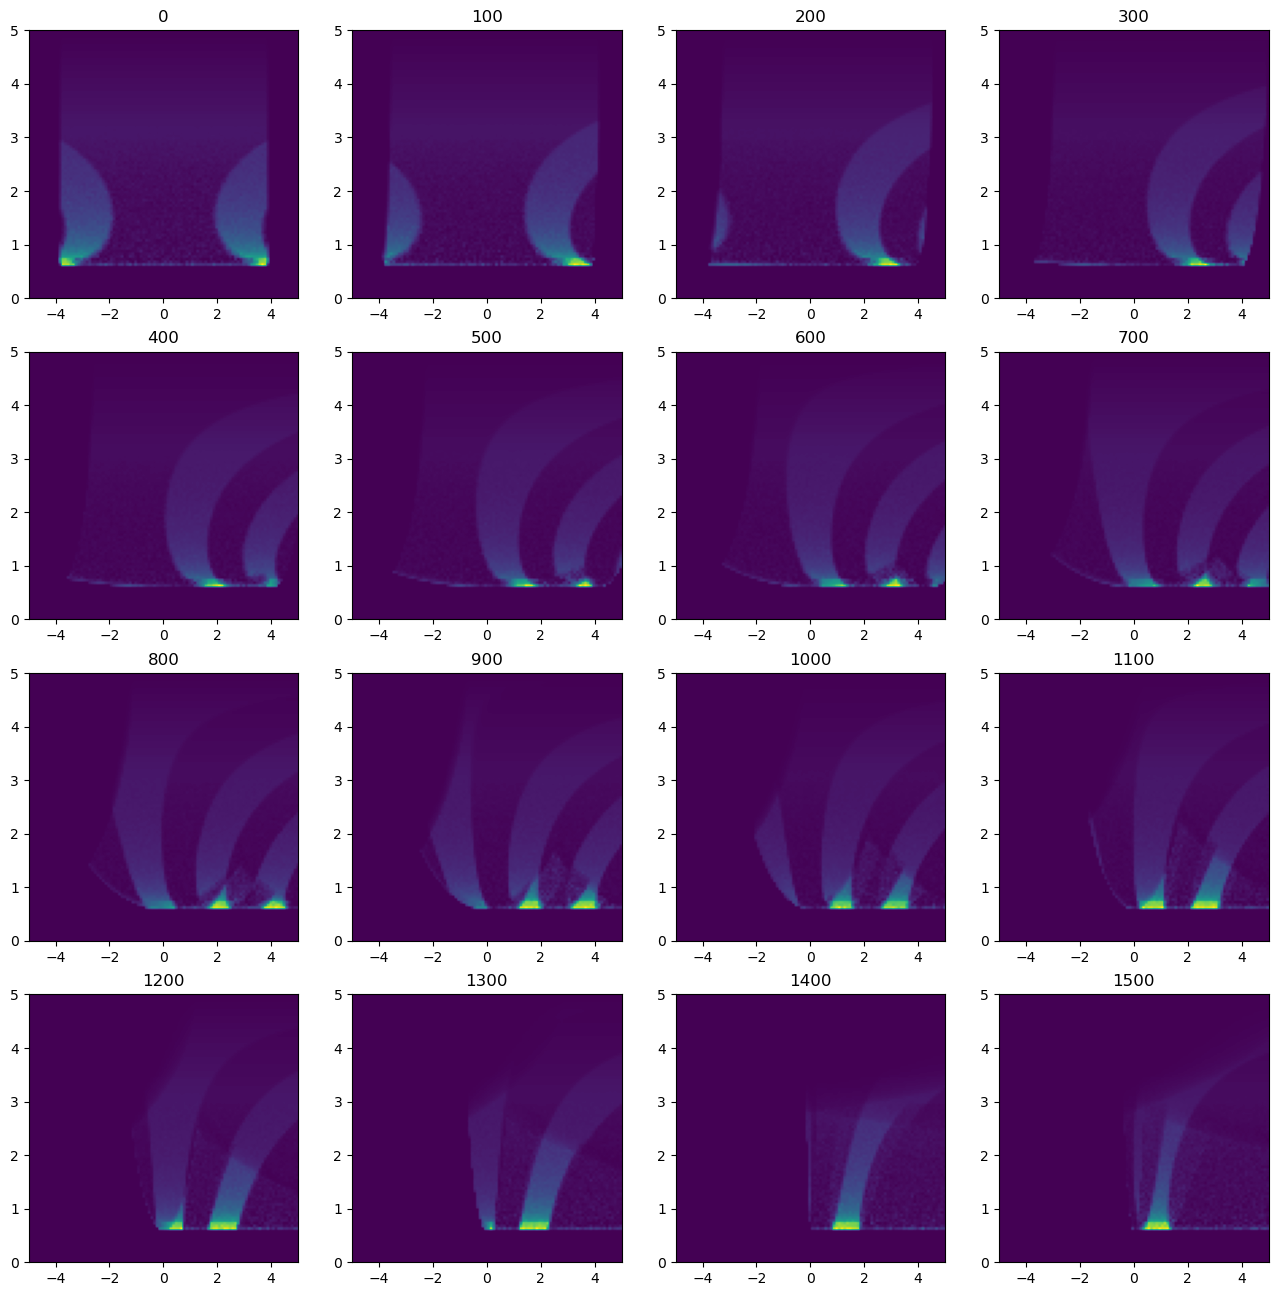

In [19]:
from matplotlib import pyplot as plt
import numpy as np

import torch
from groundtruth import Map3d, Trajectory
from integration import render
from sample import make_pose

torch.set_default_tensor_type('torch.cuda.FloatTensor')


map = Map3d('data/map.mat')
traj = Trajectory('data/traj.mat')
sigma = map.get_sigma()

rmin = 0
rmax = 5
dmin = -5
dmax = 5

r = torch.linspace(rmin, rmax, 100).cuda()
d = torch.linspace(dmin, dmax, 100).cuda()
d = d[torch.abs(d) > 0.01]


fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.reshape(-1)

for i, ax in enumerate(axs):
    # t = int(i * traj.velocity.shape[0] / len(axs))
    t = i * 100
    pose = make_pose(
        traj.velocity[t, :].squeeze(),
        traj.position[t, :].squeeze(),
        traj.orientation[t, :, :].squeeze())

    frame = render(sigma, r, d, pose)
    _frame = frame.cpu().numpy()
    ax.imshow(_frame, extent=[dmin, dmax, rmin, rmax], aspect='auto')
    ax.set_title(t)